In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = ('/content/drive/My Drive/Deep_Learning_HS_2019_0484/mini2/DFCC Historical Data .csv')
df = pd.read_csv(path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      52 non-null     object 
 1   Price     52 non-null     float64
 2   Open      52 non-null     float64
 3   High      52 non-null     float64
 4   Low       52 non-null     float64
 5   Vol.      52 non-null     object 
 6   Change %  52 non-null     object 
dtypes: float64(4), object(3)
memory usage: 3.0+ KB


In [11]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/18/2024,75.5,78.8,79.5,75.0,30.20K,-4.19%
1,02/11/2024,78.8,78.5,79.3,77.0,96.36K,0.38%
2,02/04/2024,78.5,75.0,79.8,75.0,99.61K,2.08%
3,01/28/2024,76.9,73.0,76.9,71.8,362.00K,4.20%
4,01/21/2024,73.8,75.0,75.0,71.9,88.59K,-1.60%


In [12]:
df['Price'].head()

0    75.5
1    78.8
2    78.5
3    76.9
4    73.8
Name: Price, dtype: float64

In [15]:
df = df.replace({'Vol.': {'K': '*1e3', 'M': '*1e6', 'B': '*1e9'}}, regex=True)
df['Vol.'] = pd.eval(df['Vol.']).astype(float)

In [16]:
df.dropna(inplace=True)

In [18]:
df['Change %'] = df['Change %'].replace({'%': ''}, regex=True).astype(float)

In [19]:
df.dropna(inplace=True)

In [49]:
look_back = 7
n_features = len(df.columns) - 1  # Number of features excluding 'Date'

# Function to create dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

# Preprocess the data
data = df.iloc[:, 1:].values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create the dataset with look_back
X, Y = create_dataset(scaled_data, look_back)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, n_features))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, n_features))

In [36]:
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mean_squared_error')

 Train the model

In [50]:
model.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
2/2 [==============================] - 1s 13ms/step - loss: 0.0182
Epoch 2/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0110
Epoch 4/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0135
Epoch 5/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0144
Epoch 6/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0124
Epoch 7/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0107
Epoch 8/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0110
Epoch 9/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0120
Epoch 10/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0124
Epoch 11/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0122
Epoch 12/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0123
Epoch 13/100
2/2 [==============================]

**Evaluate the model**

In [51]:
loss = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)

1/1 [==============================] - 0s 465ms/step - loss: 0.0046
Test Loss: 0.0046365465968847275


**Make predictions**

In [52]:
predictions = model.predict(X_test)

1/1 [==============================] - 0s 418ms/step


In [55]:
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform(Y_test)

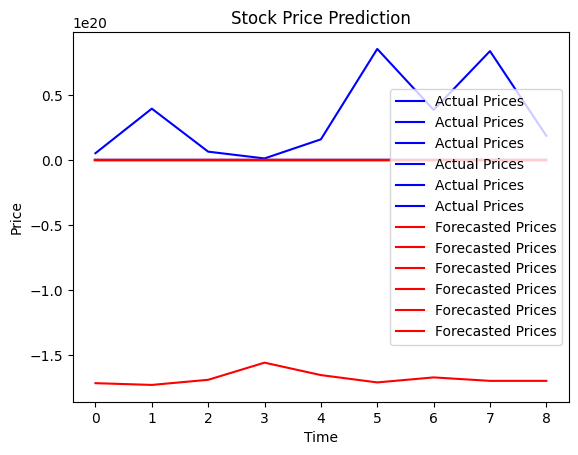

In [56]:
# Inverse transform the test set to get the actual prices
actual_prices = scaler.inverse_transform(Y_test)

# Plot the actual prices
plt.plot(actual_prices, label='Actual Prices', color='blue')

# Inverse transform the predictions to get the forecasted prices
forecasted_prices = scaler.inverse_transform(predictions)

# Plot the forecasted prices
plt.plot(forecasted_prices, label='Forecasted Prices', color='red')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()